<center><h1>Least-Squares Support Vector machine</h1></center>

## Summary:
1. [Introduction](#introduction)

2. [LSSVM CPU implementation](#lssvm_cpu)
    
3. [LSSVM GPU implementation](#lssvm_gpu)

4. [Discussing performance](#discussing_performance)

# 1. Introduction <a class="anchor" id="introduction"></a>

The Least-Squares Support Vector Machine (LSSVM) is a variation of the original Support Vector Machine (SVM) in which we have a slight change in the objective and restriction functions that results in a big simplification of the optimization problem.

First, let's see the optimization problem of an SVM:

$$ 
\begin{align}
    minimize && f_o(\vec{w},\vec{\xi})=\frac{1}{2} \vec{w}^T\vec{w} + C \sum_{i=1}^{n} \xi_i &&\\
    s.t. && d_i(\vec{w}^T\vec{x}_i+b)\geq 1 - \xi_i, && i = 1,..., n \\
         && \xi_i \geq 0,                            && i = 1,..., n
\end{align}
$$

In this case, we have a set of inequality restrictions and when solving the optimization problem by it's dual we find a discriminative function, adding the kernel trick, of the type:


$$ f(\vec{x}) = sign \ \Big( \sum_{i=1}^{n} \alpha_i^o d_i K(\vec{x}_i,\vec{x}) + b_o \Big) $$

Where $\alpha_i^o$ and $b_o$ denote optimum values. Giving enough regularization (smaller values of $C$) we get a lot of $\alpha_i^o$ nulls, resulting in a sparse model in which we only need to save the pairs $(\vec{x}_i,d_i)$ which have the optimum dual variable not null. The vectors $\vec{x}_i$ with not null $\alpha_i^o$ are known as support vectors (SV).



In the LSSVM case, we change the inequality restrictions to equality restrictions. As the $\xi_i$ may be negative we square its values in the objective function:

$$ 
\begin{align}
    minimize && f_o(\vec{w},\vec{\xi})=\frac{1}{2} \vec{w}^T\vec{w} + \gamma \frac{1}{2}\sum_{i=1}^{n} \xi_i^2 &&\\
    s.t. && d_i(\vec{w}^T\vec{x}_i+b) = 1 - \xi_i, && i = 1,..., n
\end{align}
$$


The dual of this optimization problem results in a system of linear equations, a set of Karush-Khun-Tucker (KKT) equations:

$$
\begin{bmatrix} 
    0 & \vec{d}^T \\
    \vec{d} & \Omega + \gamma^{-1} I 
\end{bmatrix}
\
\begin{bmatrix} 
    b  \\
    \vec{\alpha}
\end{bmatrix}
=
\begin{bmatrix} 
    0 \\
    \vec{1}
\end{bmatrix}
$$

Where, with the kernel trick, &nbsp; $\Omega_{i,j} = d_i d_j K(\vec{x}_i,\vec{x}_j)$,  &nbsp;  $\vec{d} = [d_1 \ d_2 \ ... \ d_n]^T$, &nbsp; $\vec{\alpha} = [\alpha_1 \ \alpha_2 \ ... \ \alpha_n]^T$ &nbsp;  e &nbsp; $\vec{1} = [1 \ 1 \ ... \ 1]^T$.

The discriminative function of the LSSVM has the same form of the SVM but the $\alpha_i^o$ aren't usually null, resulting in a bigger model. The big advantage of the LSSVM is in finding it's parameters, which is reduced to solving the linear system of the type:

$$ A\vec{x} = \vec{b} $$

A well-known solution of the linear system is when we minimize the square of the residues, that can be written as the optimization problem:

$$
\begin{align}
    minimize && f_o(\vec{x})=\frac{1}{2}||A\vec{x} - \vec{b}||^2\\
\end{align}
$$

And have the analytical solution:

$$ \vec{x} = A^{\dagger} \vec{b} $$

Where $A^{\dagger}$ is the pseudo-inverse defined as:

$$ A^{\dagger} = (A^T A)^{-1} A^T$$

# 2. LSSVM CPU implementation <a class="anchor" id="lssvm_cpu"></a>

In [1]:
import numpy as np
from numpy import dot, exp
from scipy.spatial.distance import cdist
class LSSVM:
    'Class that implements the Least-Squares Support Vector Machine.'
    def __init__(self, gamma=1, kernel='rbf', **kernel_params): 
        self.gamma = gamma      
        self.x        = None
        self.y        = None
        self.y_labels = None     
        # model params
        self.alpha = None
        self.b     = None
        self.kernel = LSSVM.get_kernel(kernel, **kernel_params)        
    @staticmethod
    def get_kernel(name, **params):   
        def linear(x_i, x_j):                           
            return dot(x_i,x_j.T)     
        
        def polynomial(x_i, x_j, d=params.get('d',3),c=params.get('c',0)):        
            return (dot(x_i,x_j.T)+c)**d   
        
        def gaussian(x_i, x_j, sigma=params.get('sigma',1)):
            if x_i.ndim==x_i.ndim and x_i.ndim==2:
                return exp(-cdist(x_i,x_j)**2/sigma**2)       
            else: 
                return exp(-(dot(x_i,x_i.T)+dot(x_j,x_j.T)-2*dot(x_i,x_j))/sigma**2)
            
        def exponential(x_i, x_j, sigma=params.get('sigma',1)):
            if x_i.ndim==x_i.ndim and x_i.ndim==2:
                return exp(-cdist(x_i,x_j)/sigma**2)       
            else: 
                return exp(-np.sqrt((2-2*dot(x_i,x_j)))/sigma**2)   
            
        def sigmoid(x_i, x_j, c=params.get('c',0)):                           
            return np.tanh(dot(x_i,x_j.T)+c)  
         
        kernels = {'linear': linear, 'polynomial': polynomial, 'gaussian': gaussian, 
                   'exponential':exponential, 'sigmoid':sigmoid}        
        if kernels.get(name) is None: 
            raise KeyError("Kernel '{}' is not defined, try one in the list: {}.".format(
                name, list(kernels.keys())))
        else: return kernels[name]
    def opt_params(self, X, y_values):
        sigma = np.multiply( y_values*y_values.T, self.kernel(X,X) )
        A_cross = np.linalg.pinv(np.block([
            [0,                           y_values.T                   ],
            [y_values,   sigma + self.gamma**-1 * np.eye(len(y_values))]
        ]))
        B = np.array([0]+[1]*len(y_values))
        solution = dot(A_cross, B)
        b     = solution[0]
        alpha = solution[1:] 
        return (b, alpha) 
    def fit(self, X, Y, verboses=0):
        self.x = X
        self.y = Y
        self.y_labels = np.unique(Y, axis=0)
        if len(self.y_labels)==2: # binary classification
            # converting to -1/+1
            y_values = np.where(
                (Y == self.y_labels[0]).all(axis=1)
                ,-1,+1)[:,np.newaxis] # making it a column vector   
            self.b, self.alpha = self.opt_params(X, y_values)  
        else: # multiclass classification
              # ONE-VS-ALL APPROACH
            n_classes = len(self.y_labels)
            self.b     = np.zeros(n_classes)
            self.alpha = np.zeros((n_classes, len(Y)))
            for i in range(n_classes):
                # converting to +1 for the desired class and -1 for all other classes
                y_values = np.where(
                    (Y == self.y_labels[i]).all(axis=1)
                    ,+1,-1)[:,np.newaxis] # making it a column vector
                self.b[i], self.alpha[i] = self.opt_params(X, y_values)     
    def predict(self, X):
        K = self.kernel(self.x, X)    
        if len(self.y_labels)==2: # binary classification
            y_values = np.where(
                (self.y == self.y_labels[0]).all(axis=1),
                -1,+1)[:,np.newaxis] # making it a column vector
            Y = np.sign(dot( np.multiply(self.alpha, y_values.flatten()), K ) + self.b)  
            y_predict_proba = dot( np.multiply(self.alpha, y_values.flatten()), K ) + self.b
            y_pred_labels = np.where(Y==-1, self.y_labels[0], 
                                     self.y_labels[1])     
        else: # multiclass classification, ONE-VS-ALL APPROACH
            Y = np.zeros((len(self.y_labels), len(X)))
            for i in range(len(self.y_labels)):
                y_values = np.where(
                    (self.y == self.y_labels[i]).all(axis=1),
                    +1, -1)[:,np.newaxis] # making it a column vector
                Y[i] = dot( np.multiply(self.alpha[i], y_values.flatten()), K ) + self.b[i] # no sign function applied        
            predictions = np.argmax(Y, axis=0)
            y_pred_labels = np.array([self.y_labels[i] for i in predictions])
        return y_pred_labels, y_predict_proba

Running a single test in all data sets:

In [2]:
import scipy.io as scio

dataFile = 'finally experiment data\S1_train_value_WPE_1.mat'
xTr_n = scio.loadmat(dataFile)['S1_train_value_WPE_1']
dataFile = 'finally experiment data\S1_test_value_WPE_1.mat'
xTe_n = scio.loadmat(dataFile)['S1_test_value_WPE_1']

dataFile = 'finally experiment data\yTr.mat'
yTr = scio.loadmat(dataFile)['yTr']
dataFile = 'finally experiment data\yTe.mat'
yTe = scio.loadmat(dataFile)['yTe']

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  
import numpy as np  
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt

In [4]:
gamma_array = np.arange(-1000, 1000, .7)
print(len(gamma_array))
Accuracy_array = []
for i in range(len(gamma_array)):
    lssvm = LSSVM(gamma=float(gamma_array[i]), kernel='linear')
    lssvm.fit(xTr_n, yTr)
    y_pred_labels_linear, y_predict_proba_linear = lssvm.predict(xTe_n)
    C = confusion_matrix(yTe, y_pred_labels_linear)
    TP = C[0][0]
    FP = C[0][1]
    FN = C[1][0]
    TN = C[1][1]
    Accuracy = (TP+TN)/(TP+FP+TN+FN)
    Accuracy_array.append(Accuracy)

2858


In [5]:
print(max(Accuracy_array))
print(Accuracy_array.index(max(Accuracy_array)))
print(gamma_array[Accuracy_array.index(max(Accuracy_array))])

0.8611111111111112
1458
20.600000000066302


In [6]:
print('linear kernel')
lssvm = LSSVM(gamma=gamma_array[Accuracy_array.index(max(Accuracy_array))], kernel='linear')
lssvm.fit(xTr_n, yTr)
y_pred_labels_linear, y_predict_proba_linear = lssvm.predict(xTe_n)
C = confusion_matrix(yTe, y_pred_labels_linear)
scio.savemat('y_predict_proba_linear.mat',{"y_predict_proba_linear":y_predict_proba_linear})
TP = C[0][0]
FP = C[0][1]
FN = C[1][0]
TN = C[1][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Specificity = TN/(TN+FP)
F1 = (2*Precision*Recall)/(Precision+Recall)
print('Accuracy ',Accuracy)
print('Precision ',Precision)
print('Recall ',Recall)
print('Specificity ',Specificity)
print('F1 ',F1)
print(C)

linear kernel
Accuracy  0.8611111111111112
Precision  0.7777777777777778
Recall  0.9333333333333333
Specificity  0.8095238095238095
F1  0.8484848484848485
[[56 16]
 [ 4 68]]


In [7]:
gamma_array = np.arange(-1000, 1000, .7)
sigma_array = np.arange(0.1, 100, .5)
print(len(gamma_array))
print(len(sigma_array))

Accuracy_array = np.zeros([len(gamma_array),len(sigma_array)])
for i in range(len(gamma_array)):
    for j in range(len(sigma_array)):
        lssvm = LSSVM(gamma=gamma_array[i], kernel='gaussian', sigma=sigma_array[j])
        lssvm.fit(xTr_n, yTr)
        y_pred_labels_gaussian, y_predict_proba_gaussian = lssvm.predict(xTe_n)
        C = confusion_matrix(yTe, y_pred_labels_gaussian)
        TP = C[0][0]
        FP = C[0][1]
        FN = C[1][0]
        TN = C[1][1]
        Accuracy = (TP+TN)/(TP+FP+TN+FN)
        Accuracy_array[i][j] = Accuracy
            

2858
200


In [8]:
print(Accuracy_array.size)
print(Accuracy_array.max())
index = np.where(Accuracy_array==np.max(Accuracy_array))
print(gamma_array[index[0][0]])
print(sigma_array[index[1][0]])

571600
0.9375
45.100000000067894
0.6


In [9]:
print('gaussian kernel')
lssvm = LSSVM(gamma=gamma_array[index[0][0]], kernel='gaussian', sigma=sigma_array[index[1][0]])
lssvm.fit(xTr_n, yTr)
y_pred_labels_gaussian, y_predict_proba_gaussian = lssvm.predict(xTe_n)
C = confusion_matrix(yTe, y_pred_labels_gaussian)
scio.savemat('y_predict_proba_gaussian.mat',{"y_predict_proba_gaussian":y_predict_proba_gaussian})
TP = C[0][0]
FP = C[0][1]
FN = C[1][0]
TN = C[1][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Specificity = TN/(TN+FP)
F1 = (2*Precision*Recall)/(Precision+Recall)
print('Accuracy ',Accuracy)
print('Precision ',Precision)
print('Recall ',Recall)
print('Specificity ',Specificity)
print('F1 ',F1)
print(C)

gaussian kernel
Accuracy  0.9375
Precision  0.8888888888888888
Recall  0.9846153846153847
Specificity  0.8987341772151899
F1  0.9343065693430657
[[64  8]
 [ 1 71]]


In [10]:
gamma_array = np.arange(-1000, 1000, .7)
sigma_array = np.arange(0.1, 100, .5)
print(len(gamma_array))
print(len(sigma_array))

Accuracy_array = np.zeros([len(gamma_array),len(sigma_array)])
for i in range(len(gamma_array)):
    for j in range(len(sigma_array)):
        lssvm = LSSVM(gamma=gamma_array[i], kernel='exponential', sigma=sigma_array[j])
        lssvm.fit(xTr_n, yTr)
        y_pred_labels_exponential, y_predict_proba_exponential = lssvm.predict(xTe_n)
        C = confusion_matrix(yTe, y_pred_labels_exponential)
        TP = C[0][0]
        FP = C[0][1]
        FN = C[1][0]
        TN = C[1][1]
        Accuracy = (TP+TN)/(TP+FP+TN+FN)
        Accuracy_array[i][j] = Accuracy
            

2858
200


In [11]:
print(Accuracy_array.size)
print(Accuracy_array.max())
index = np.where(Accuracy_array==np.max(Accuracy_array))
print(gamma_array[index[0][0]])
print(sigma_array[index[1][0]])

571600
0.9375
-931.3999999999955
9.6


In [12]:
print('exponential kernel')
lssvm = LSSVM(gamma=gamma_array[index[0][0]], kernel='exponential', sigma=sigma_array[index[1][0]])
lssvm.fit(xTr_n, yTr)
y_pred_labels_exponential, y_predict_proba_exponential = lssvm.predict(xTe_n)
C = confusion_matrix(yTe, y_pred_labels_exponential)
scio.savemat('y_predict_proba_exponential.mat',{"y_predict_proba_exponential":y_predict_proba_exponential})
TP = C[0][0]
FP = C[0][1]
FN = C[1][0]
TN = C[1][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Specificity = TN/(TN+FP)
F1 = (2*Precision*Recall)/(Precision+Recall)
print('Accuracy ',Accuracy)
print('Precision ',Precision)
print('Recall ',Recall)
print('Specificity ',Specificity)
print('F1 ',F1)
print(C)

exponential kernel
Accuracy  0.9375
Precision  0.8888888888888888
Recall  0.9846153846153847
Specificity  0.8987341772151899
F1  0.9343065693430657
[[64  8]
 [ 1 71]]


In [13]:
gamma_array = np.arange(-1000, 1000, .7)
c_array = np.arange(-10, 10, .5)
print(len(gamma_array))
print(len(c_array))

Accuracy_array = np.zeros([len(gamma_array),len(c_array)])
for i in range(len(gamma_array)):
    for j in range(len(c_array)):
        lssvm = LSSVM(gamma=gamma_array[i], kernel='sigmoid',c=c_array[j])
        lssvm.fit(xTr_n, yTr)
        y_pred_labels_sigmoid, y_predict_proba_sigmoid = lssvm.predict(xTe_n)
        C = confusion_matrix(yTe, y_pred_labels_sigmoid)
        TP = C[0][0]
        FP = C[0][1]
        FN = C[1][0]
        TN = C[1][1]
        Accuracy = (TP+TN)/(TP+FP+TN+FN)
        Accuracy_array[i][j] = Accuracy
            

2858
40


In [14]:
print(Accuracy_array.size)
print(Accuracy_array.max())
index = np.where(Accuracy_array==np.max(Accuracy_array))
print(gamma_array[index[0][0]])
print(c_array[index[1][0]])

114320
0.9166666666666666
-1000.0
-0.5


In [15]:
print('sigmoid kernel')
lssvm = LSSVM(gamma=gamma_array[index[0][0]], kernel='sigmoid',c=c_array[index[1][0]])
lssvm.fit(xTr_n, yTr)
y_pred_labels_sigmoid, y_predict_proba_sigmoid = lssvm.predict(xTe_n)
C = confusion_matrix(yTe, y_pred_labels_sigmoid)
scio.savemat('y_predict_proba_sigmoid.mat',{"y_predict_proba_sigmoid":y_predict_proba_sigmoid})
TP = C[0][0]
FP = C[0][1]
FN = C[1][0]
TN = C[1][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Specificity = TN/(TN+FP)
F1 = (2*Precision*Recall)/(Precision+Recall)
print('Accuracy ',Accuracy)
print('Precision ',Precision)
print('Recall ',Recall)
print('Specificity ',Specificity)
print('F1 ',F1)
print(C)

sigmoid kernel
Accuracy  0.9166666666666666
Precision  0.8333333333333334
Recall  1.0
Specificity  0.8571428571428571
F1  0.9090909090909091
[[60 12]
 [ 0 72]]


In [16]:
gamma_array = np.arange(-1000, 1000, .7)
d_array = np.arange(1, 10)
c_array = np.arange(-10, 10, .5)
print(len(gamma_array))
print(len(d_array))
print(len(c_array))

Accuracy_array = np.zeros([len(gamma_array),len(d_array),len(c_array)])
for i in range(len(gamma_array)):
    for j in range(len(d_array)):
        for k in range(len(c_array)):
            lssvm = LSSVM(gamma=gamma_array[i], kernel='polynomial', d=d_array[j], c=c_array[k])
            lssvm.fit(xTr_n, yTr)
            y_pred_labels_polynomial, y_predict_proba_polynomial = lssvm.predict(xTe_n)
            C = confusion_matrix(yTe, y_pred_labels_polynomial)
            TP = C[0][0]
            FP = C[0][1]
            FN = C[1][0]
            TN = C[1][1]
            Accuracy = (TP+TN)/(TP+FP+TN+FN)
            Accuracy_array[i][j][k] = Accuracy

2858
9
40


In [17]:
print(Accuracy_array.size)
print(Accuracy_array.max())
index = np.where(Accuracy_array==np.max(Accuracy_array))
print(gamma_array[index[0][0]])
print(d_array[index[1][0]])
print(c_array[index[2][0]])

1028880
0.9513888888888888
222.2000000000794
3
-0.5


In [18]:
print('polynomial kernel')
lssvm = LSSVM(gamma=gamma_array[index[0][0]], kernel='polynomial', d=d_array[index[1][0]], c=c_array[index[2][0]])
lssvm.fit(xTr_n, yTr)
y_pred_labels_polynomial, y_predict_proba_polynomial = lssvm.predict(xTe_n)
C = confusion_matrix(yTe, y_pred_labels_polynomial)
scio.savemat('y_predict_proba_polynomial.mat',{"y_predict_proba_polynomial":y_predict_proba_polynomial})
TP = C[0][0]
FP = C[0][1]
FN = C[1][0]
TN = C[1][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Specificity = TN/(TN+FP)
F1 = (2*Precision*Recall)/(Precision+Recall)
print('Accuracy ',Accuracy)
print('Precision ',Precision)
print('Recall ',Recall)
print('Specificity ',Specificity)
print('F1 ',F1)
print(C)

polynomial kernel
Accuracy  0.9513888888888888
Precision  0.9305555555555556
Recall  0.9710144927536232
Specificity  0.9333333333333333
F1  0.9503546099290779
[[67  5]
 [ 2 70]]


In [19]:
def plot_roc(labels, predict_prob, name):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic curves')
    label='AUC = %0.4f'% roc_auc
    label = name+label
    plt.plot(false_positive_rate, true_positive_rate,label=label)
    plt.legend(loc='lower right')
    plt.ylabel('TPR')
    plt.xlabel('FPR')

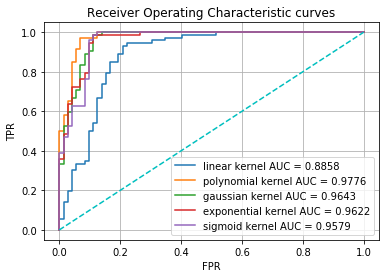

In [20]:
plt.grid()  # 生成网格
plot_roc(yTe,y_predict_proba_linear,name='linear kernel ')
plot_roc(yTe,y_predict_proba_polynomial,name='polynomial kernel ')
plot_roc(yTe,y_predict_proba_gaussian,name='gaussian kernel ')
plot_roc(yTe,y_predict_proba_exponential,name='exponential kernel ')
plot_roc(yTe,y_predict_proba_sigmoid,name='sigmoid kernel ')
plt.plot([0,1],[0,1],'c--',label='lucky')
plt.savefig("ROC.svg",dpi=800)